In [5]:
import torch

In [6]:
torch.cuda.is_available()

False

import os
import numpy as np
import shutil
import pandas as pd


def train_test_split():
    print("########### Train Test Val Script started ###########")
    #data_csv = pd.read_csv("DataSet_Final.csv") ##Use if you have classes saved in any .csv file

    root_dir = 'dataset'
    classes_dir = ['aluminium_foil',
                   'brown_bread',
                   'corduroy',
                   'cotton',
                   'cracker',
                   'linen',
                   'orange_peel',
                   'sandpaper',
                   'sponge',
                   'styrofoam']

    #for name in data_csv['names'].unique()[:10]:
    #    classes_dir.append(name)

    processed_dir = 'KTH_TIPS'

    val_ratio = 0.10
    test_ratio = 0.05

    for cls in classes_dir:
        # Creating partitions of the data after shuffeling
        print("$$$$$$$ Class Name " + cls + " $$$$$$$")
        src = processed_dir +"//" + cls  # Folder to copy images from

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                                   int(len(allFileNames) * (1 - val_ratio)),
                                                                   ])

        train_FileNames = [src + '//' + name for name in train_FileNames.tolist()]
        val_FileNames = [src + '//' + name for name in val_FileNames.tolist()]
        test_FileNames = [src + '//' + name for name in test_FileNames.tolist()]

        print('Total images: '+ str(len(allFileNames)))
        print('Training: '+ str(len(train_FileNames)))
        print('Validation: '+  str(len(val_FileNames)))
        print('Testing: '+ str(len(test_FileNames)))

        # # Creating Train / Val / Test folders (One time use)
        os.makedirs(root_dir + '/train//' + cls)
        os.makedirs(root_dir + '/val//' + cls)
        os.makedirs(root_dir + '/test//' + cls)

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, root_dir + '/train//' + cls)

        for name in val_FileNames:
            shutil.copy(name, root_dir + '/val//' + cls)

        for name in test_FileNames:
            shutil.copy(name, root_dir + '/test//' + cls)

    print("########### Train Test Val Script Ended ###########")

train_test_split()

# Transfer Learning

In [7]:
# import the necessary packages
import torch
import os

# define path to the original dataset and base path to the dataset
# splits
DATA_PATH = "KTH_TIPS"
BASE_PATH = "dataset"

# define validation split and paths to separate train and validation
# splits
VAL_SPLIT = 0.1
TRAIN = os.path.join(BASE_PATH, "train")
VAL = os.path.join(BASE_PATH, "val")

In [32]:
# specify ImageNet mean and standard deviation and image size
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 120
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [75]:
# specify training hyperparameters
FEATURE_EXTRACTION_BATCH_SIZE = 256
FINETUNE_BATCH_SIZE = 8
PRED_BATCH_SIZE = 4
EPOCHS = 20
LR = 0.001
LR_FINETUNE = 0.0005

In [12]:
# import the necessary packages
from torch.utils.data import DataLoader
from torchvision import datasets
import os

In [27]:
def get_dataloader(rootDir, transforms, batchSize, shuffle=True):
    # create a dataset and use it to create a data loader
    ds = datasets.ImageFolder(root=rootDir,
        transform=transforms)
    loader = DataLoader(ds, batch_size=batchSize,
        shuffle=shuffle,
        num_workers=os.cpu_count(),
        pin_memory=True if DEVICE == "cuda" else False)
    # return a tuple of  the dataset and the data loader
    return (ds, loader)

In [33]:
from torchvision import transforms

# define augmentation pipelines
trainTansform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])
valTransform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [34]:
(trainDS, trainLoader) = get_dataloader(TRAIN,
    transforms=trainTansform,
    batchSize=FEATURE_EXTRACTION_BATCH_SIZE)

(valDS, valLoader) = get_dataloader(VAL,
    transforms=valTransform,
    batchSize=FEATURE_EXTRACTION_BATCH_SIZE, shuffle=False)

In [41]:
from torchvision.models import resnet18
from torch import nn

# load up the ResNet50 model
model = resnet18(pretrained=True)

# since we are using the ResNet50 model as a feature extractor we set
# its parameters to non-trainable (by default they are trainable)

for param in model.parameters():
    param.requires_grad = False
# append a new classification top to our feature extractor and pop it
# on to the current device

modelOutputFeats = model.fc.in_features
model.fc = nn.Linear(modelOutputFeats, len(trainDS.classes))
model = model.to(DEVICE)

In [42]:
# initialize loss function and optimizer (notice that we are only
# providing the parameters of the classification top to our optimizer)

lossFunc = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.fc.parameters(), lr=LR)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // FEATURE_EXTRACTION_BATCH_SIZE
valSteps = len(valDS) // FEATURE_EXTRACTION_BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "train_acc": [], "val_loss": [],
    "val_acc": []}

In [48]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(EPOCHS)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    # loop over the training set
    
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunc(pred, y)
        # calculate the gradients
        loss.backward()
        
        # check if we are updating the model parameters and if so
        # update them, and zero out the previously accumulated gradients
        if (i + 2) % 2 == 0:
            opt.step()
            opt.zero_grad()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(
            torch.float).sum().item()
        
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x, y) in valLoader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFunc(pred, y)
            # calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(
                torch.float).sum().item()
            
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(valDS)
    # update our training history
    
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
        avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
        avgValLoss, valCorrect))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

[INFO] training the network...


  5%|████▏                                                                              | 1/20 [00:17<05:31, 17.43s/it]

[INFO] EPOCH: 1/20
Train loss: 3.426782, Train accuracy: 0.1338
Val loss: inf, Val accuracy: 0.2750


 10%|████████▎                                                                          | 2/20 [00:38<05:49, 19.41s/it]

[INFO] EPOCH: 2/20
Train loss: 3.049737, Train accuracy: 0.2735
Val loss: inf, Val accuracy: 0.3500


 15%|████████████▍                                                                      | 3/20 [00:59<05:43, 20.22s/it]

[INFO] EPOCH: 3/20
Train loss: 2.722867, Train accuracy: 0.4294
Val loss: inf, Val accuracy: 0.4750


 20%|████████████████▌                                                                  | 4/20 [01:21<05:38, 21.14s/it]

[INFO] EPOCH: 4/20
Train loss: 2.417410, Train accuracy: 0.5574
Val loss: inf, Val accuracy: 0.5500


 25%|████████████████████▊                                                              | 5/20 [01:44<05:22, 21.51s/it]

[INFO] EPOCH: 5/20
Train loss: 2.190095, Train accuracy: 0.6353
Val loss: inf, Val accuracy: 0.5750


 30%|████████████████████████▉                                                          | 6/20 [02:06<05:04, 21.77s/it]

[INFO] EPOCH: 6/20
Train loss: 1.959883, Train accuracy: 0.6912
Val loss: inf, Val accuracy: 0.5500


 35%|█████████████████████████████                                                      | 7/20 [02:28<04:45, 21.96s/it]

[INFO] EPOCH: 7/20
Train loss: 1.718613, Train accuracy: 0.7676
Val loss: inf, Val accuracy: 0.5750


 40%|█████████████████████████████████▏                                                 | 8/20 [02:50<04:23, 21.97s/it]

[INFO] EPOCH: 8/20
Train loss: 1.563459, Train accuracy: 0.7956
Val loss: inf, Val accuracy: 0.5750


 45%|█████████████████████████████████████▎                                             | 9/20 [03:13<04:05, 22.28s/it]

[INFO] EPOCH: 9/20
Train loss: 1.418730, Train accuracy: 0.8074
Val loss: inf, Val accuracy: 0.6000


 50%|█████████████████████████████████████████                                         | 10/20 [03:35<03:42, 22.27s/it]

[INFO] EPOCH: 10/20
Train loss: 1.352392, Train accuracy: 0.8191
Val loss: inf, Val accuracy: 0.6250


 55%|█████████████████████████████████████████████                                     | 11/20 [03:59<03:23, 22.61s/it]

[INFO] EPOCH: 11/20
Train loss: 1.191728, Train accuracy: 0.8485
Val loss: inf, Val accuracy: 0.6750


 60%|█████████████████████████████████████████████████▏                                | 12/20 [04:23<03:05, 23.13s/it]

[INFO] EPOCH: 12/20
Train loss: 1.148586, Train accuracy: 0.8397
Val loss: inf, Val accuracy: 0.7000


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [04:47<02:42, 23.25s/it]

[INFO] EPOCH: 13/20
Train loss: 1.053506, Train accuracy: 0.8456
Val loss: inf, Val accuracy: 0.6750


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [05:08<02:16, 22.79s/it]

[INFO] EPOCH: 14/20
Train loss: 0.953248, Train accuracy: 0.8809
Val loss: inf, Val accuracy: 0.7500


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [05:31<01:53, 22.71s/it]

[INFO] EPOCH: 15/20
Train loss: 0.938888, Train accuracy: 0.8632
Val loss: inf, Val accuracy: 0.7250


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [05:52<01:29, 22.32s/it]

[INFO] EPOCH: 16/20
Train loss: 0.921843, Train accuracy: 0.8676
Val loss: inf, Val accuracy: 0.7750


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [06:13<01:05, 21.84s/it]

[INFO] EPOCH: 17/20
Train loss: 0.857219, Train accuracy: 0.8838
Val loss: inf, Val accuracy: 0.8000


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [06:34<00:43, 21.69s/it]

[INFO] EPOCH: 18/20
Train loss: 0.814072, Train accuracy: 0.8824
Val loss: inf, Val accuracy: 0.7500


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [06:56<00:21, 21.53s/it]

[INFO] EPOCH: 19/20
Train loss: 0.798957, Train accuracy: 0.8765
Val loss: inf, Val accuracy: 0.7750


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:17<00:00, 21.86s/it]

[INFO] EPOCH: 20/20
Train loss: 0.753600, Train accuracy: 0.8926
Val loss: inf, Val accuracy: 0.7750
[INFO] total time taken to train the model: 437.11s


NameError: name 'plt' is not defined

In [52]:
# serialize the model to disk
torch.save(model, 'results/nn1_pretrained')

# Fine-tuning

In [49]:
#trainTansform = transforms.Compose([
#    transforms.RandomResizedCrop(IMAGE_SIZE),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomRotation(90),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=MEAN, std=STD)
#])
#valTransform = transforms.Compose([
#    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=MEAN, std=STD)
#])

In [76]:
(trainDS, trainLoader) = get_dataloader('crops/train',
    transforms=trainTansform, batchSize=FINETUNE_BATCH_SIZE)
(valDS, valLoader) = get_dataloader('crops/test',
    transforms=valTransform, batchSize=FINETUNE_BATCH_SIZE,
    shuffle=False)

In [77]:
# load up the ResNet50 model
model = torch.load('results/pretrained/nn1_pretrained')
numFeatures = model.fc.in_features

# loop over the modules of the model and set the parameters of
# batch normalization modules as not trainable
for module, param in zip(model.modules(), model.parameters()):
    if isinstance(module, nn.BatchNorm2d):
        param.requires_grad = False
# define the network head and attach it to the model
headModel = nn.Sequential(
    nn.Linear(numFeatures, 512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(trainDS.classes))
)
model.fc = headModel
# append a new classification top to our feature extractor and pop it
# on to the current device
model = model.to(DEVICE)

In [96]:
# initialize loss function and optimizer (notice that we are only
# providing the parameters of the classification top to our optimizer)
lossFunc = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=LR_FINETUNE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // FINETUNE_BATCH_SIZE
valSteps = len(valDS) // FINETUNE_BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "train_acc": [], "val_loss": [],
    "val_acc": []}

[INFO] training the network...


 10%|████████▎                                                                          | 1/10 [00:13<02:00, 13.34s/it]

[INFO] EPOCH: 1/10
Train loss: 0.445013, Train accuracy: 0.8841
Val loss: 0.939361, Val accuracy: 0.8333


 20%|████████████████▌                                                                  | 2/10 [00:27<01:51, 13.88s/it]

[INFO] EPOCH: 2/10
Train loss: 0.432729, Train accuracy: 0.8696
Val loss: 0.994146, Val accuracy: 0.8333


 30%|████████████████████████▉                                                          | 3/10 [00:43<01:43, 14.81s/it]

[INFO] EPOCH: 3/10
Train loss: 0.601257, Train accuracy: 0.8116
Val loss: 1.070592, Val accuracy: 0.5833


 40%|█████████████████████████████████▏                                                 | 4/10 [00:58<01:30, 15.05s/it]

[INFO] EPOCH: 4/10
Train loss: 0.570482, Train accuracy: 0.8406
Val loss: 1.010555, Val accuracy: 0.7500


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:14<01:16, 15.22s/it]

[INFO] EPOCH: 5/10
Train loss: 0.546554, Train accuracy: 0.8406
Val loss: 0.999179, Val accuracy: 0.8333


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:30<01:01, 15.34s/it]

[INFO] EPOCH: 6/10
Train loss: 0.622531, Train accuracy: 0.8116
Val loss: 0.936983, Val accuracy: 0.8333


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:45<00:46, 15.41s/it]

[INFO] EPOCH: 7/10
Train loss: 0.641753, Train accuracy: 0.7826
Val loss: 0.908651, Val accuracy: 0.7500


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:01<00:30, 15.42s/it]

[INFO] EPOCH: 8/10
Train loss: 0.579277, Train accuracy: 0.8551
Val loss: 0.944853, Val accuracy: 0.8333


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:16<00:15, 15.41s/it]

[INFO] EPOCH: 9/10
Train loss: 0.593984, Train accuracy: 0.8116
Val loss: 1.007508, Val accuracy: 0.8333


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:31<00:00, 15.18s/it]

[INFO] EPOCH: 10/10
Train loss: 0.473323, Train accuracy: 0.8696
Val loss: 0.941815, Val accuracy: 0.7500
[INFO] total time taken to train the model: 151.79s


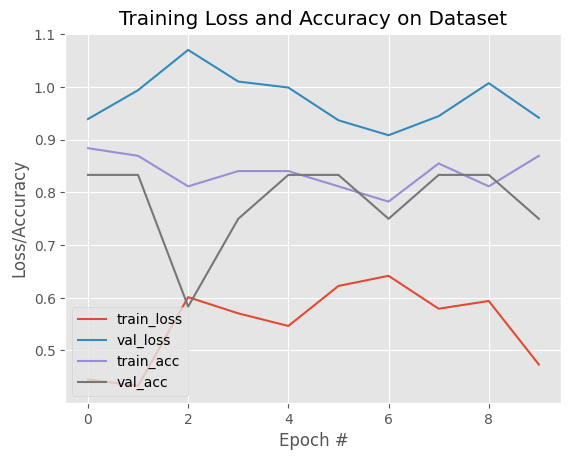

In [97]:
# loop over epochs
print("[INFO] training the network...")
EPOCHS_fine = 10
startTime = time.time()
for e in tqdm(range(EPOCHS_fine)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunc(pred, y)
        # calculate the gradients
        loss.backward()
        # check if we are updating the model parameters and if so
        # update them, and zero out the previously accumulated gradients
        if (i + 2) % 2 == 0:
            opt.step()
            opt.zero_grad()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(
            torch.float).sum().item()
        
        
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x, y) in valLoader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFunc(pred, y)
            # calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(
                torch.float).sum().item()
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(valDS)
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS_fine))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
        avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
        avgValLoss, valCorrect))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [98]:
# serialize the model to disk
torch.save(model, 'results/fine_tuned/nn3')

# Testing Results

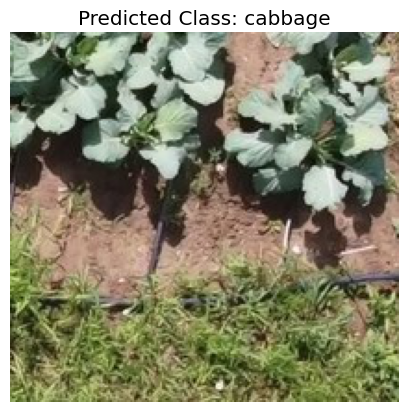

In [110]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder('crops/train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

classes = train_dataset.classes

# Визуализация предсказаний
sample_image = Image.open('./crops/test/cabbage/4.jpg')
sample_image_tensor = transform(sample_image).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    model.eval()
    output = model(sample_image_tensor)
    _, predicted_index = torch.max(output.data, 1)
    prob = torch.nn.functional.softmax(output, dim=1)
    
    if prob.max().item() > 0.7:
        predicted_class = classes[predicted_index.item()]
    else:
        predicted_class = 'None'

plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

In [111]:
# Script 
from PIL import Image
import torch
import torchvision
from torchvision import transforms, datasets
from torch.nn.functional import softmax
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def crop_predict_image(path_image: str, model: torchvision.models.resnet.ResNet):
    '''
    Функция принимает на вход путь к изображению, разрезает его,
    каждый фрагмент отправляет в модель.
    Выходное значение - список тензоров с вероятноястями.
    '''
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    image = Image.open(path_image)
    width, height = image.size
    
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    
    train_dataset = datasets.ImageFolder('crops/train', transform=transform)
    classes = train_dataset.classes
    
    # Список из списков с тензорами вероятностей классов
    predicted_output = [[] for lst in range(0, 19)]
    
    # Настройки для отрисовывания
    colors = ['red', 'blue', 'yellow', 'green', 'orange', 'brown', 'white', 'black']
    
    classes_colors = dict(zip(range(0, 100), zip(classes, colors)))
    
    draw = ImageDraw.Draw(image)
    
    upper = 0
    lower = round(height * 0.1)
    
    row = -1
    
    for h in range(0, 19):
        row += 1
        left = 0
        right = round(width * 0.1)
        
        for w in range(0, 19):
            cropped_image = image.crop((left, upper, right, lower))
            transfromed_image = transform(cropped_image).unsqueeze(0).to(device)
            
            predicted = softmax(model(transfromed_image), -1)
            
            predicted_output[row].append(predicted)
            
            if float(torch.max(predicted)) > 0.75:
                index = int(torch.argmax(predicted))
                
                draw.line((left, upper, right, upper), fill=classes_colors[index][1], width=10)
                draw.line((right, upper, right, lower), fill=classes_colors[index][1], width=10)
                draw.line((left, lower, right, lower), fill=classes_colors[index][1], width=10)
                draw.line((left, lower, left, upper), fill=classes_colors[index][1], width=10)
            
            left += round(width * 0.1)
            right += round(width * 0.1)
            
        upper += round(height * 0.1)
        lower += round(height * 0.1)
    
    text = ''
    for i in classes_colors:
        text = text + classes_colors[i][0] + ' - ' + classes_colors[i][1] + ' \n'
    
    plt.figure(figsize=(16, 12))
    plt.imshow(image)
    plt.axis('off')
    plt.title(text)
    plt.show()
    
    return image, predicted_output, classes

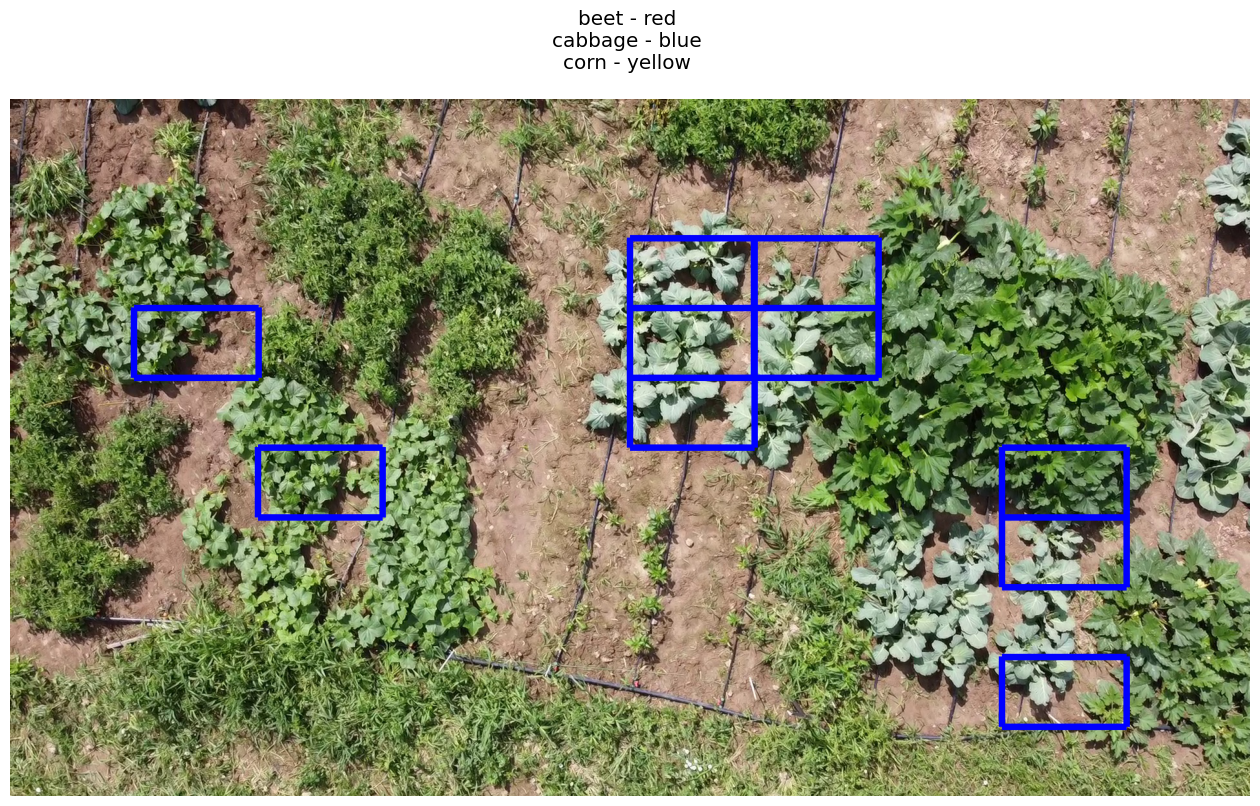

In [112]:
image, predicted_output, classes = crop_predict_image('./test_multiple/frame6059.jpg', model)

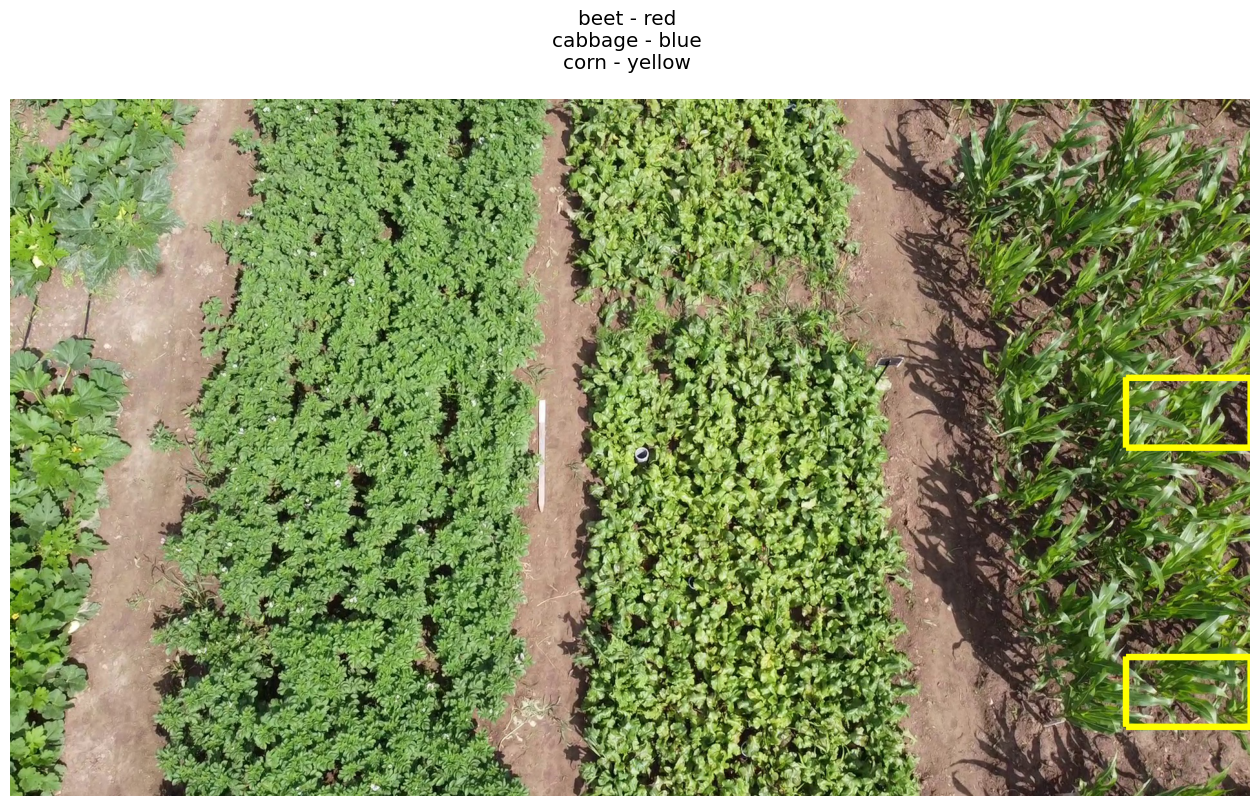

In [113]:
image, predicted_output, classes = crop_predict_image('./test_multiple/frame2300.jpg', model)